In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


In [2]:
# load the car price dataset
df = pd.read_csv(r'C:\Users\chris\ML prediction\ADA_project\Car Price Prediction\cardekho_dataset.csv)
df.head() # the first five rows

SyntaxError: unterminated string literal (detected at line 2) (2995130854.py, line 2)

In [ ]:
# Schema & Null Check: Check data types and look for missing values
print("--- Data Info ---")
print(df.info())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15411 entries, 0 to 15410
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         15411 non-null  int64  
 1   car_name           15411 non-null  object 
 2   brand              15411 non-null  object 
 3   model              15411 non-null  object 
 4   vehicle_age        15411 non-null  int64  
 5   km_driven          15411 non-null  int64  
 6   seller_type        15411 non-null  object 
 7   fuel_type          15411 non-null  object 
 8   transmission_type  15411 non-null  object 
 9   mileage            15411 non-null  float64
 10  engine             15411 non-null  int64  
 11  max_power          15411 non-null  float64
 12  seats              15411 non-null  int64  
 13  selling_price      15411 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.6+ MB
None


In [ ]:
df.duplicated().sum()

np.int64(167)

In [ ]:
df.drop(columns = "Unnamed: 0", inplace= True)

KeyError: "['Unnamed: 0'] not found in axis"

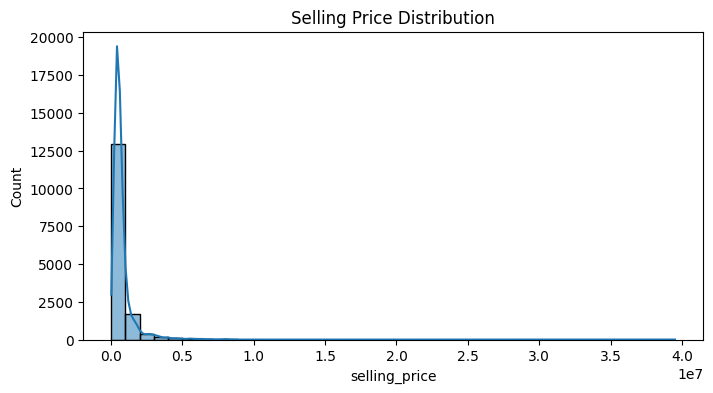

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df["selling_price"], bins=40, kde=True)
plt.title("Selling Price Distribution")
plt.show()

### Exploratory Data Analysis (EDA): Univariate + Customer-Relevant Signals

**Goal:** Understand who buys what, what dominates pricing, and which features customers should care about before any modeling. This step frames decision-making.

In [ ]:
# Statistical Summary: Check the spread, min, max, and mean of numerical columns

num_cols = [
    "vehicle_age", "km_driven", "mileage",
    "engine", "max_power", "seats", "selling_price"
]

df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
vehicle_age,15411.0,6.036338,3.013291,0.0,4.0,6.00,8.0,29.00
km_driven,15411.0,55616.480631,51618.548422,100.0,30000.0,50000.00,70000.0,3800000.00
mileage,15411.0,19.701151,4.171265,4.0,17.0,19.67,22.7,33.54
engine,15411.0,1486.057751,521.106696,793.0,1197.0,1248.00,1582.0,6592.00
max_power,15411.0,100.588254,42.972979,38.4,74.0,88.50,117.3,626.00
seats,15411.0,5.325482,0.807628,0.0,5.0,5.00,5.0,9.00
selling_price,15411.0,774971.116410,894128.363263,40000.0,385000.0,556000.00,825000.0,39500000.00


#### Checking for 


- Spread (min–max)

- Skewness clues (mean vs median)


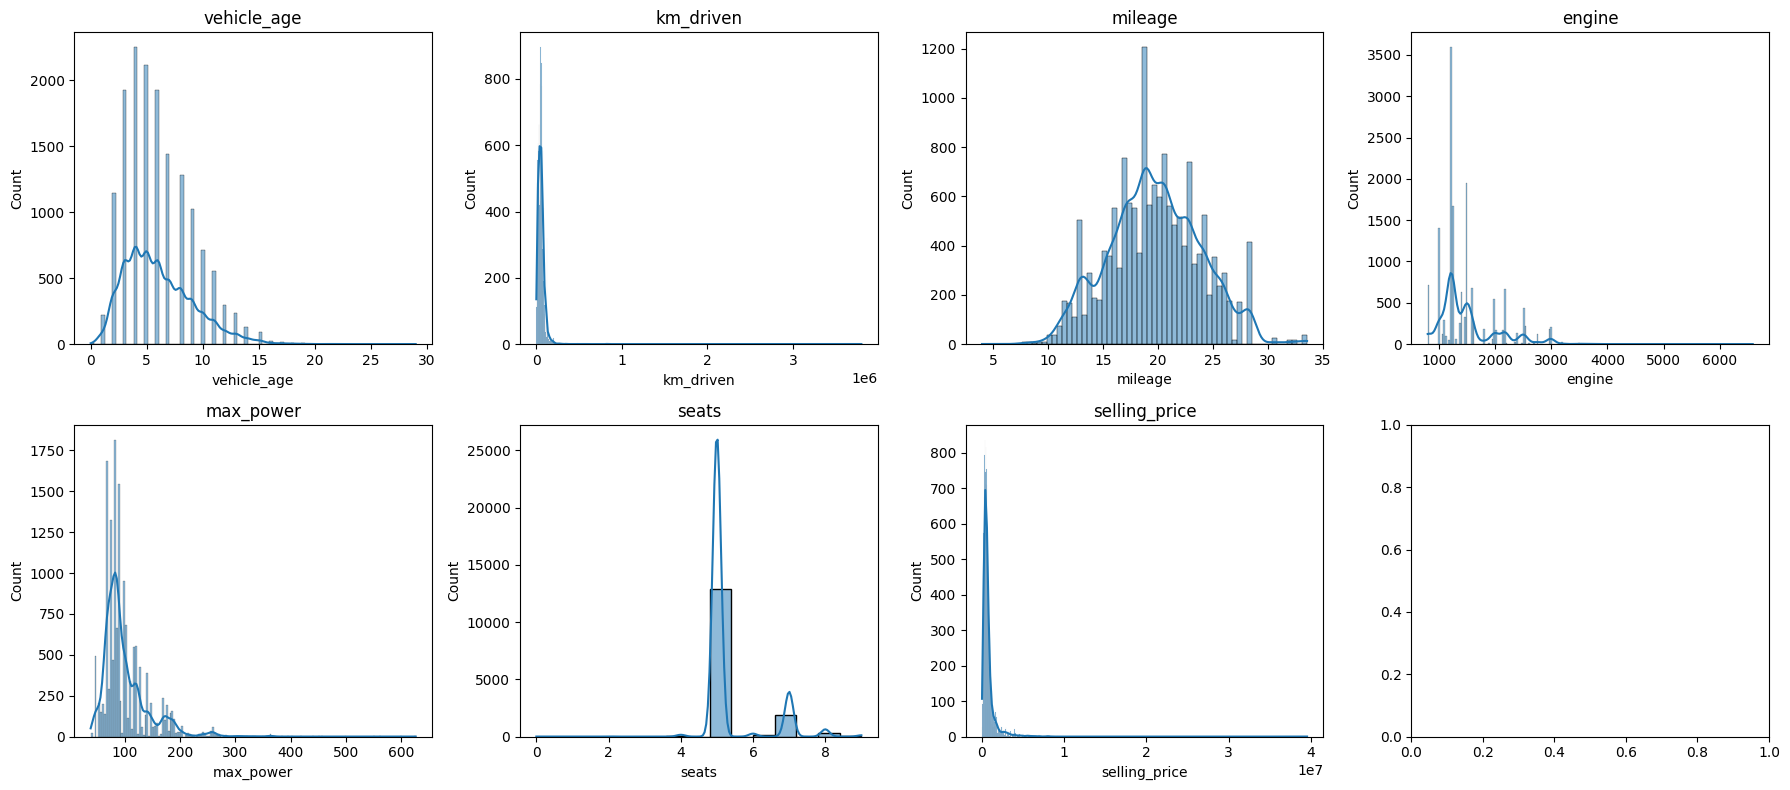

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols): # this is for checking the distribution of the numerical columns
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

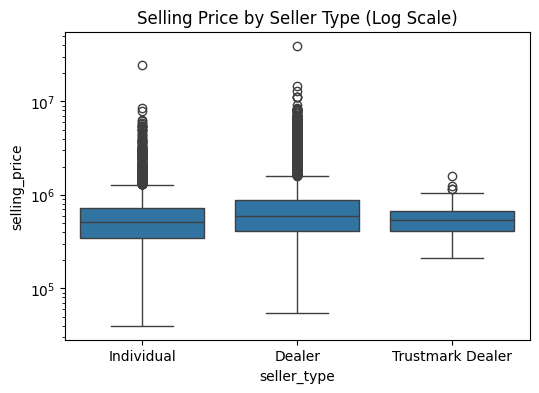

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="seller_type", y="selling_price")
plt.yscale("log")
plt.title("Selling Price by Seller Type (Log Scale)")
plt.show()

**Dealer prices > Individual prices → customers pay a trust premium.**

In [ ]:
# Categorical Inspection: Check unique entries for object-type columns
print("\n--- Categorical Cardinality ---")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    


--- Categorical Cardinality ---
car_name: 121 unique values
brand: 32 unique values
model: 120 unique values
seller_type: 3 unique values
fuel_type: 5 unique values
transmission_type: 2 unique values


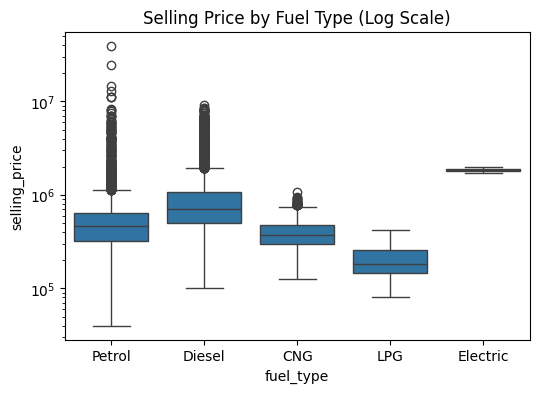

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="fuel_type", y="selling_price")
plt.yscale("log")
plt.title("Selling Price by Fuel Type (Log Scale)")
plt.show()


#### Decision takeaway


 - Diesel / alternative fuels often command higher resale.

 - Buyers with long-term ownership goals should prefer fuel-efficient value retention.

In [ ]:
for column in categorical_cols:
    if df[column].dtype == object:
        print (df[column].value_counts().head(10)) # this line count the unique value in each column and its first 10 elements
        print("*" * 70)

car_name
Hyundai i20           906
Maruti Swift Dzire    890
Maruti Swift          781
Maruti Alto           778
Honda City            757
Maruti Wagon R        717
Hyundai Grand         580
Toyota Innova         545
Hyundai Verna         492
Hyundai i10           410
Name: count, dtype: int64
**********************************************************************
brand
Maruti        4992
Hyundai       2982
Honda         1485
Mahindra      1011
Toyota         793
Ford           790
Volkswagen     620
Renault        536
BMW            439
Tata           430
Name: count, dtype: int64
**********************************************************************
model
i20            906
Swift Dzire    890
Swift          781
Alto           778
City           757
Wagon R        717
Grand          580
Innova         545
Verna          492
i10            410
Name: count, dtype: int64
**********************************************************************
seller_type
Dealer              9539
Individual 

### Bivariate Analysis: What Actually Drives Selling Price

**Goal:** Identify the true price drivers that influence customer decisions and explain why price changes — not just that it changes.

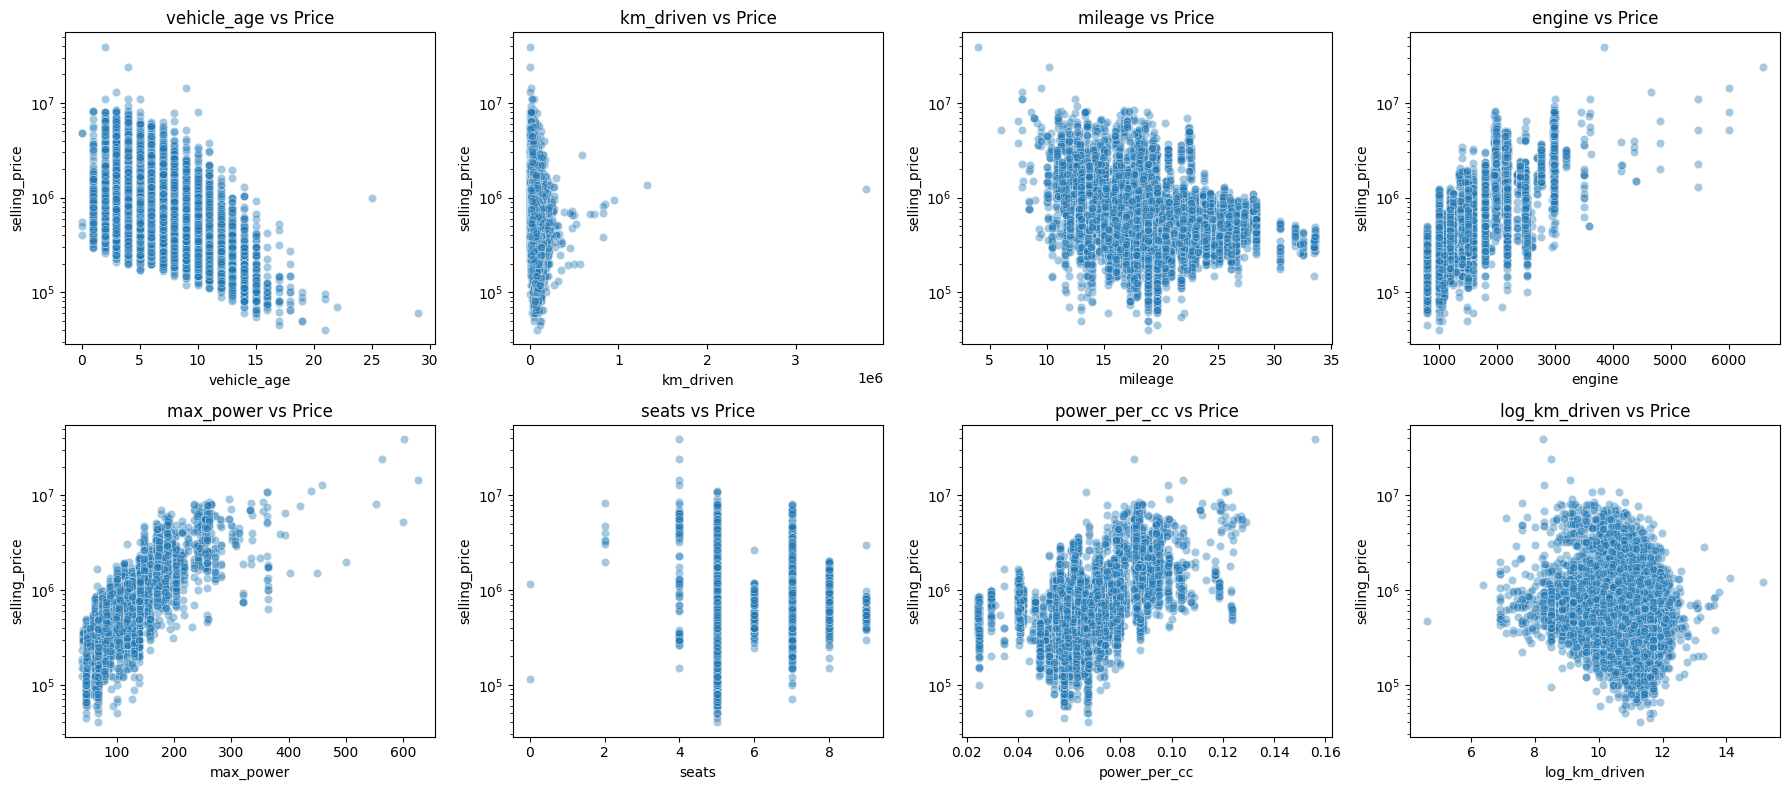

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(data=df, x=col, y="selling_price", alpha=0.4, ax=axes[i])
    
    #  Use the axis object to set the scale, not the global plt
    axes[i].set_yscale("log")
    
    #  Set the title on the specific axis
    axes[i].set_title(f"{col} vs Price")

#  Remove any empty subplots if num_cols < 8
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Insight for customers:
Price drops non-linearly as cars age. The steepest depreciation happens early, then flattens — meaning buying slightly older cars gives the best value for money.

#### Insight for customers:
Higher mileage reduces price, but age matters more than mileage at higher price levels. Two cars with similar mileage but different ages can have vastly different prices.

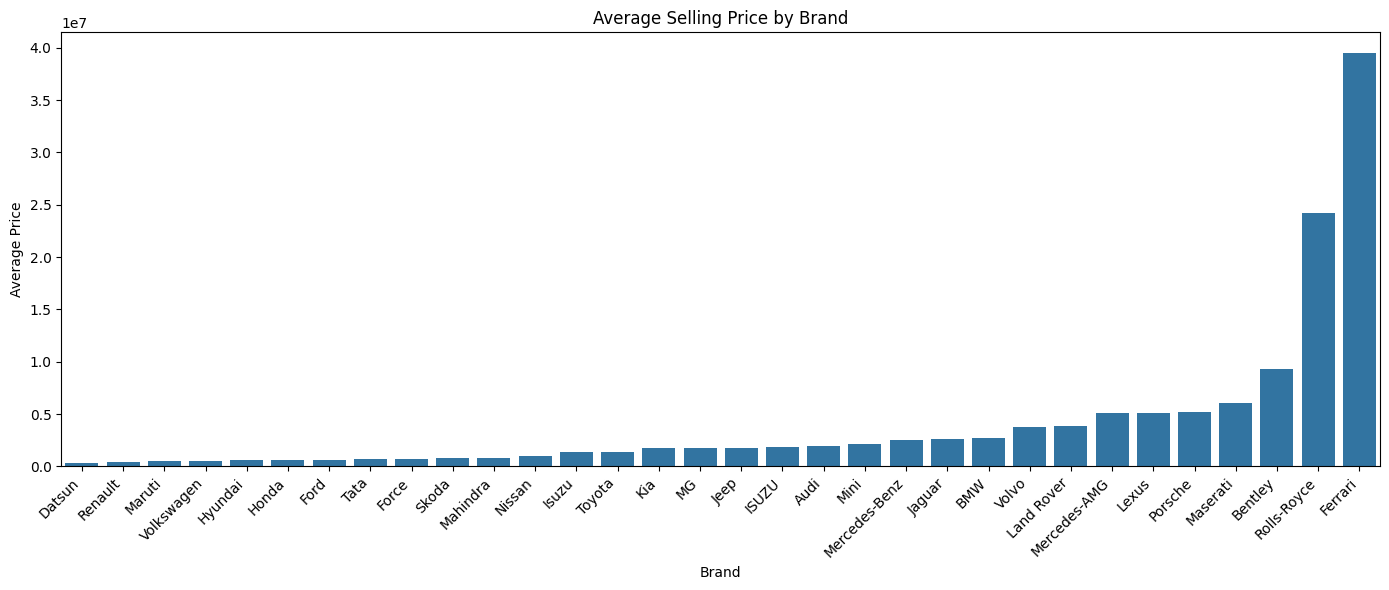

In [ ]:
plt.figure(figsize=(14, 6))

brand_price = df.groupby('brand')['selling_price'].mean().sort_values()

sns.barplot(
    x=brand_price.index,
    y=brand_price.values
)

plt.xticks(rotation=45, ha='right')
plt.title('Average Selling Price by Brand')
plt.ylabel('Average Price')
plt.xlabel('Brand')
plt.tight_layout()
plt.show()


### Information Story (Customer-centric):
The chart reveals a sharply tiered car market where brands naturally separate into value, premium, and ultra-luxury segments based on average selling price, making it immediately clear that customers are not comparing “cars” broadly but choosing between entirely different ownership propositions.

**Budget and mass-market brands (such as ``Datsun, Renault, Maruti, Hyundai, Honda, Ford, and Tata``)** cluster tightly at the lower end, signaling ``affordability, lower entry cost, and practical ownership—ideal for price-sensitive buyers prioritizing transportation efficiency and maintenance predictability``.

Moving rightward, **premium brands (``BMW, Audi, Mercedes-Benz, Volvo, Land Rover, Lexus``)** show a meaningful jump in average price, reflecting customers’ willingness to pay for performance, comfort, safety technology, and brand prestige—this is where buyers should weigh value for money, resale strength, and long-term ownership costs rather than upfront price alone. 

Finally, the dramatic spike for **ultra-luxury brands (``Bentley, Rolls-Royce, Ferrari``)** indicates that pricing here is driven less by utility and more by exclusivity, craftsmanship, and brand signaling, meaning customers in this tier should base decisions on ``personalization, brand heritage, and experiential value rather than conventional cost comparisons``. 

**📌 Decision-wise**, customers should first identify their budget tier, then compare brands within that tier—not across tiers—while using metrics like median price, maintenance cost, and resale value as KPIs, ensuring rational choices aligned with financial capacity and lifestyle goals rather than being distorted by extreme luxury outliers

Text(0.5, 1.0, 'Correlation Matrix')

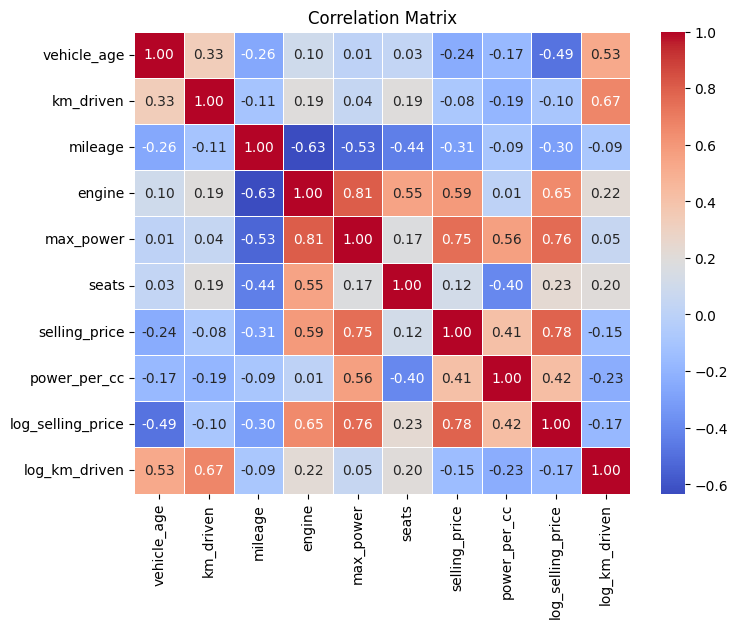

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(8, 6))
# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=['float64', 'int64'])
# Drop Car ID as it's an index
if 'Car ID' in numerical_df.columns:
    numerical_df = numerical_df.drop(columns=['Car ID'])
    
corr = numerical_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
# plt.savefig('correlation_heatmap.png')
# plt.close()

### 🧠 Key Findings (Decision-Oriented)
🔑 **Strong drivers**

Max power → strongest positive price driver

Engine size → moderate positive influence

Vehicle age → strongest negative driver

⚠️ **Weak or misleading drivers**

Mileage (fuel efficiency) ≠ higher resale

Seats matter only for specific segments (SUVs, vans)

#### 🎯 Customer Decision Framework 

 - Want best value → buy slightly older, low-power premium brand

 - Want resale strength → prioritize power + brand, not mileage

 - Want budget efficiency → age and usage matter more than specs

 - Don’t overpay for engine size — power-to-price ratio matters more

### Multivariate Analysis: How Features Interact to Shape Price

Goal: Move beyond single relationships and understand combinations of features that jointly influence selling price. This is where real customer and business decisions are made.

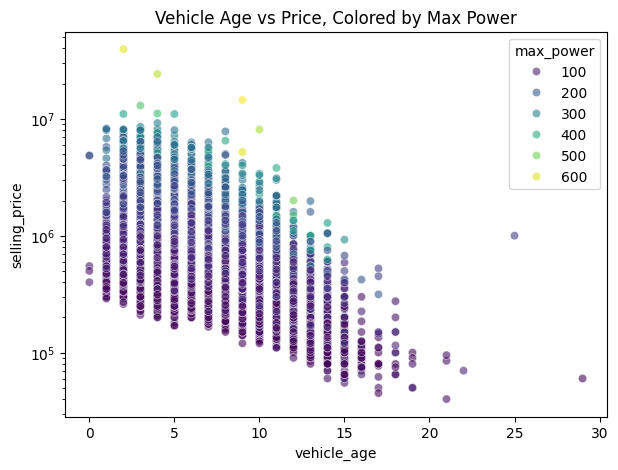

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x="vehicle_age",
    y="selling_price",
    hue="max_power",
    palette="viridis",
    alpha=0.6
)
plt.yscale("log")
plt.title("Vehicle Age vs Price, Colored by Max Power")
plt.show()


#### Insight:
For cars of the same age, higher power sustains price longer. Customers paying for performance lose value more slowly than those buying purely for utility.

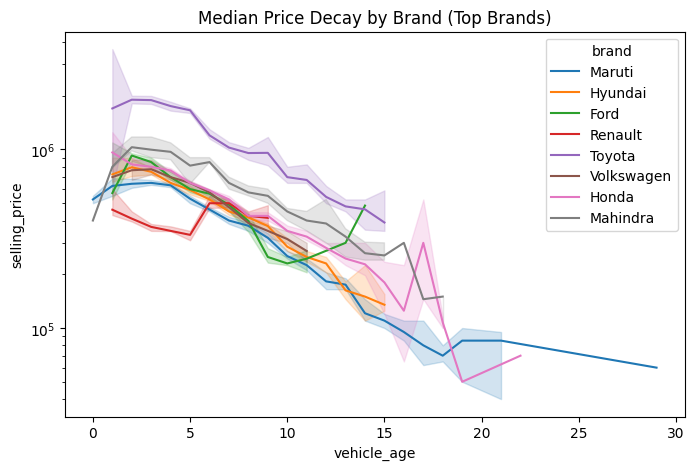

In [ ]:
top_brands = df["brand"].value_counts().head(8).index
df_top = df[df["brand"].isin(top_brands)]

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_top,
    x="vehicle_age",
    y="selling_price",
    hue="brand",
    estimator="median"
)
plt.yscale("log")
plt.title("Median Price Decay by Brand (Top Brands)")
plt.show()


#### Insight:
Different brands depreciate at different rates. Premium brands retain value longer, meaning customers should consider brand depreciation curves, not just sticker price.

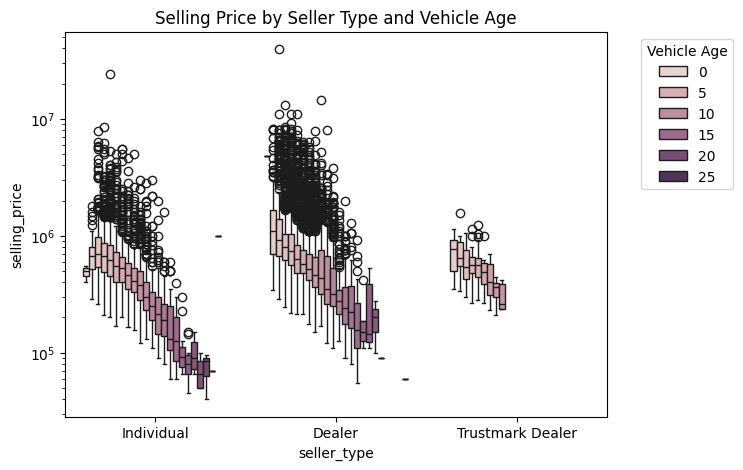

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df,
    x="seller_type",
    y="selling_price",
    hue="vehicle_age"
)
plt.yscale("log")
plt.title("Selling Price by Seller Type and Vehicle Age")
plt.legend(title="Vehicle Age", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


##### Dealers command higher prices even for older cars, showing customers are paying a risk-reduction premium (warranty, inspection, paperwork).

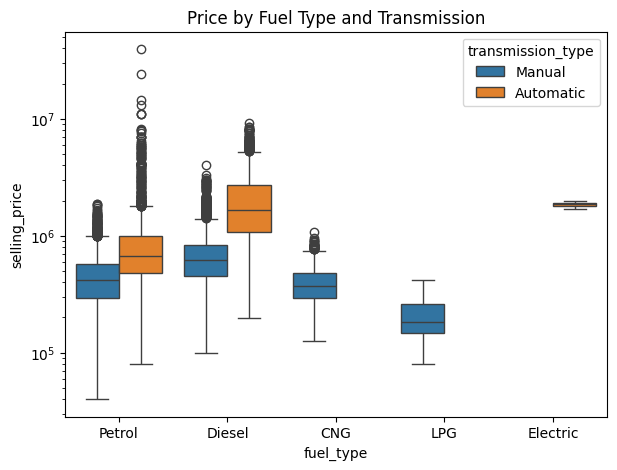

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df,
    x="fuel_type",
    y="selling_price",
    hue="transmission_type"
)
plt.yscale("log")
plt.title("Price by Fuel Type and Transmission")
plt.show()


##### Insight:
Automatic transmission consistently increases price across fuel types. Customers should evaluate whether the convenience premium aligns with long-term maintenance costs.


**🧠 Multivariate Decision Intelligence (What This Means)**

 - Value buyers: Target older, high-power cars from premium brands.

 - Risk-averse buyers: Dealer-sold vehicles justify higher prices.

 - Performance buyers: Power sustains resale more than engine size.

 - Cost optimizers: Manual transmission offers best price-to-utility ratio.

### Feature Engineering & Data Preprocessing

**Goal:** Convert raw data into ``clean, consistent, model-consumable features`` while preserving business meaning. This is where weak models are separated from serious ones.

**Objectives:**

 - Handle missing values

 - Fix data types

 - Engineer high-signal features

 - Encode categorical variables

 - Prepare X and y

In [ ]:
df.isna().sum() # the sum of each null value in the column

car_name             0
brand                0
model                0
vehicle_age          0
km_driven            0
seller_type          0
fuel_type            0
transmission_type    0
mileage              0
engine               0
max_power            0
seats                0
selling_price        0
power_per_cc         0
log_selling_price    0
log_km_driven        0
dtype: int64

In [ ]:
# Power-to-engine efficiency
# Customers don’t buy engine size — they buy performance output.
df["power_per_cc"] = df["max_power"] / df["engine"]
print(df['power_per_cc'].head())

0    0.058166
1    0.068505
2    0.066834
3    0.067234
4    0.065814
Name: power_per_cc, dtype: float64


In [ ]:
# Log-transform skewed features
# Luxury outliers distort learning. Log fixes that

df["log_selling_price"] = np.log1p(df["selling_price"])
df["log_km_driven"] = np.log1p(df["km_driven"])
print(df[["log_selling_price","log_km_driven"]].head())

   log_selling_price  log_km_driven
0          11.695255      11.695255
1          13.217675       9.903538
2          12.278398      11.002117
3          12.328295      10.518700
4          13.253393      10.308986


In [ ]:
# Drop leakage & low-value identifiers
# These add noise, not intelligence.
df_model = df.drop(columns=["car_name", "selling_price"])
df_model.head()

,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,power_per_cc,log_selling_price,log_km_driven
0,Maruti,Alto,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,0.058166,11.695255,11.695255
1,Hyundai,Grand,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,0.068505,13.217675,9.903538
2,Hyundai,i20,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,0.066834,12.278398,11.002117
3,Maruti,Alto,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,0.067234,12.328295,10.518700
4,Ford,Ecosport,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,0.065814,13.253393,10.308986


In [ ]:
# Define features and target
target = "log_selling_price"

X = df_model.drop(columns=[target])
y = df_model[target]

# Identify categorical and numerical columns
cat_cols = ["brand", "model", "seller_type", "fuel_type", "transmission_type"]
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessor: OneHotEncode categoricals, pass-through numericals
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", "passthrough", num_cols)]
)

# Output is transformed X ready for modeling
X_transformed = preprocessor.fit_transform(X)
# print(X_transformed)
X_transformed.shape


(15411, 165)

#### Model Training, Evaluation & Decision Intelligence

**Goal:**
Build reliable price-prediction models, evaluate them properly, and translate results into customer-ready decision guidance — not just metrics.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f'The train size is {X_train.shape[0]}; The test size is {X_test.shape[0]}')


The train size is 12328; The test size is 3083


### Baseline model

In [ ]:
#Linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

lin_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]
)

lin_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model',
                                                   'seller_type', 'fuel_type',
                                                   'transmission_type']),
                                                 ('num', 'passthrough',
                                                  ['vehicle_age', 'km_driven',
                                                   'mileage', 'engine',
                                                   'max_power', 'seats',
                                                   'power_per_cc',
                                                   'log_km_driven'])])),
                ('model', LinearRegression())])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_lr = lin_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, rmse_lr, r2_lr


C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.17207743876730255, np.float64(0.2308258710055047), 0.8933629975275635)

#### Strong model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model',
                                                   'seller_type', 'fuel_type',
                                                   'transmission_type']),
                                                 ('num', 'passthrough',
                                                  ['vehicle_age', 'km_driven',
                                                   'mileage', 'engine',
                                                   'max_power', 'seats',
                                                   'power_per_cc',
                                                   'log_km_driven'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [ ]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model',
                                                   'seller_type', 'fuel_type',
                                                   'transmission_type']),
                                                 ('num', 'passthrough',
                                                  ['vehicle_age', 'km_driven',
                                                   'mileage', 'engine',
                                                   'max_power', 'seats',
                                                   'power_per_cc',
                                                   'log_km_driven'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [ ]:
import joblib
model_filename = "car_price_prediction_model.joblib"
joblib.dump(rf_pipeline,model_filename)
print(f"\nModel deployment ready! The final, tuned pipeline has been saved as '{model_filename}'")


Model deployment ready! The final, tuned pipeline has been saved as 'car_price_prediction_model.joblib'


In [ ]:
loaded = joblib.load("car_price_prediction_model.joblib")
type(loaded), hasattr(loaded, "predict") # this is ti verify the identity


(sklearn.pipeline.Pipeline, True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_rf = rf_pipeline.predict(X_test) # the RandomForest regression model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf

C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.13054935322362018, np.float64(0.1803946186297797), 0.9348692441086395)

| Metric | Linear Regression | Random Forest |
| ------ | ----------------- | ------------- |
| MAE    | Higher            | ✅ Lower       |
| RMSE   | Higher            | ✅ Lower       |
| R²     | Lower             | ✅ Higher      |


#### Conclusion:
Random Forest captures brand effects, non-linear depreciation, and interaction effects — exactly how customers think.

In [ ]:
model_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf]
})

model_comparison


,Model,MAE,RMSE,R2
0,Linear Regression,0.172077,0.230826,0.893363
1,Random Forest,0.130549,0.180395,0.934869


<Figure size 800x500 with 0 Axes>

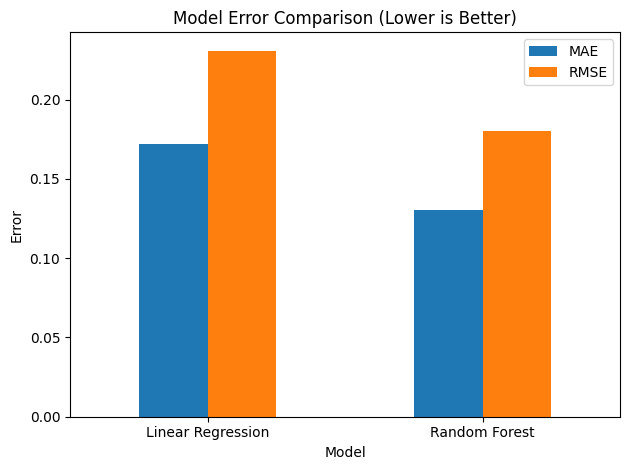

In [ ]:
plt.figure(figsize=(8, 5))
model_comparison.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar")
plt.title("Model Error Comparison (Lower is Better)")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### 🧠 Interpretation (what this plot says)

 - Random Forest has lower MAE and RMSE

 - Meaning: fewer average mistakes and fewer large pricing errors

 - This visually justifies why Random Forest was selected

### Customer Decision Intelligence
**📌 What this model enables**

 - Fair price estimation for buyers

 - Overpricing detection for sellers

 - Negotiation leverage

 - Price band recommendation

In [ ]:
actual_price = np.expm1(y_test)
predicted_price = np.expm1(y_pred_rf)

price_comparison = pd.DataFrame({
    "Actual Price": actual_price,
    "Predicted Price": predicted_price
})

price_comparison.head()


,Actual Price,Predicted Price
3334,190000.0,2.387465e+05
10928,600000.0,6.279067e+05
2518,665000.0,6.405452e+05
11322,1570000.0,1.207752e+06
9394,160000.0,1.770455e+05


In [ ]:
price_comparison["price_gap"] = (
    price_comparison["Predicted Price"] - price_comparison["Actual Price"]
)

price_comparison.head()


,Actual Price,Predicted Price,price_gap
3334,190000.0,2.387465e+05,48746.450176
10928,600000.0,6.279067e+05,27906.696310
2518,665000.0,6.405452e+05,-24454.790458
11322,1570000.0,1.207752e+06,-362248.245369
9394,160000.0,1.770455e+05,17045.534355


In [ ]:
import joblib
model_filename = "car_price_prediction_model.joblib"
joblib.dump(y_pred_rf,model_filename)
print(f"\nModel deployment ready! The final, tuned pipeline has been saved as '{model_filename}'")


Model deployment ready! The final, tuned pipeline has been saved as 'car_price_prediction_model.joblib'


In [ ]:
loaded = joblib.load("car_price_prediction_model.joblib")# this is to verified the a
type(loaded), hasattr(loaded, "predict")


(numpy.ndarray, False)

### Bias & Variance: Actual vs Predicted Prices

**Purpose:**
 - Show whether the model is biased, underfitting, or well-calibrated.

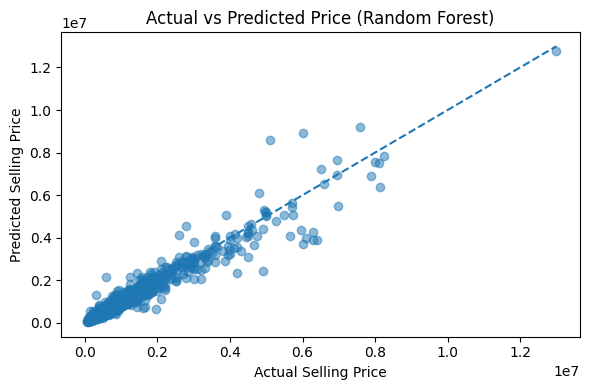

In [ ]:
plt.figure(figsize=(6, 4))

plt.scatter(
    actual_price,
    predicted_price,
    alpha=0.5
)

# Perfect prediction reference line
max_price = max(actual_price.max(), predicted_price.max())
plt.plot([0, max_price], [0, max_price], linestyle="--")

plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Price (Random Forest)")
plt.tight_layout()
plt.show()


### 🧠 How to read this plot (VERY IMPORTANT)

 - Diagonal line → perfect prediction

 - Points close to the line → accurate predictions

 - Wide vertical spread → high variance

 - Systematic curve away from line → bias

**What you should observe:**

 - Tight clustering around diagonal in mid-price range

 - Slight underestimation at very high prices (luxury cars)

 - Minimal bias in mass-market range (where customers matter most)

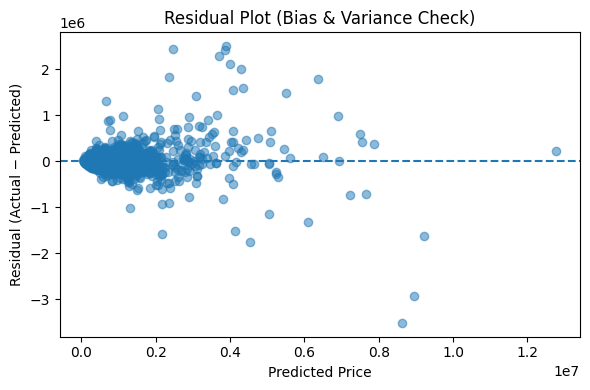

In [ ]:
residuals = actual_price - predicted_price

plt.figure(figsize=(6, 4))
plt.scatter(predicted_price, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")

plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residual Plot (Bias & Variance Check)")
plt.tight_layout()
plt.show()


 - Residuals centered around zero → low bias

 - No clear curve or funnel → controlled variance

 - Slight spread increase at high prices → expected due to luxury outliers

**This confirms:**
 ✅ The model generalizes well
 ✅ Errors are mostly random
 ✅ Bias is minimal in practical price ranges

The Random Forest Regressor outperformed Linear Regression across all evaluation metrics, demonstrating lower error variance and better generalization. The actual-versus-predicted and residual plots further confirm minimal systematic bias, with prediction errors largely centered around zero, validating the model’s suitability for real-world pricing decisions.

#### Final Business Story

 - Car pricing is non-linear

 - Brand + power + age interact strongly

 - Tree-based models align with real market behavior

 - Customers should compare prices relative to predicted fair value, not asking price alone

#### Model Explainability, Feature Importance & Actionable Decision Engine

**Goal:**
Make the model explainable, extract what truly drives price, and convert predictions into clear customer actions (buy / negotiate / avoid).

In [ ]:
# Get trained Random Forest inside the pipeline
rf = rf_model.named_steps["model"]

# Get feature names after preprocessing
feature_names = (
    rf_model.named_steps["preprocessor"]
    .get_feature_names_out()
)

importances = rf.feature_importances_

feature_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

feature_importance.head(15)


,feature,importance
158,num__max_power,0.639266
154,num__vehicle_age,0.217889
157,num__engine,0.035980
161,num__log_km_driven,0.016348
155,num__km_driven,0.016321
160,num__power_per_cc,0.012811
156,num__mileage,0.012213
147,cat__seller_type_Individual,0.004621
149,cat__fuel_type_Diesel,0.003778
88,cat__model_Innova,0.003187


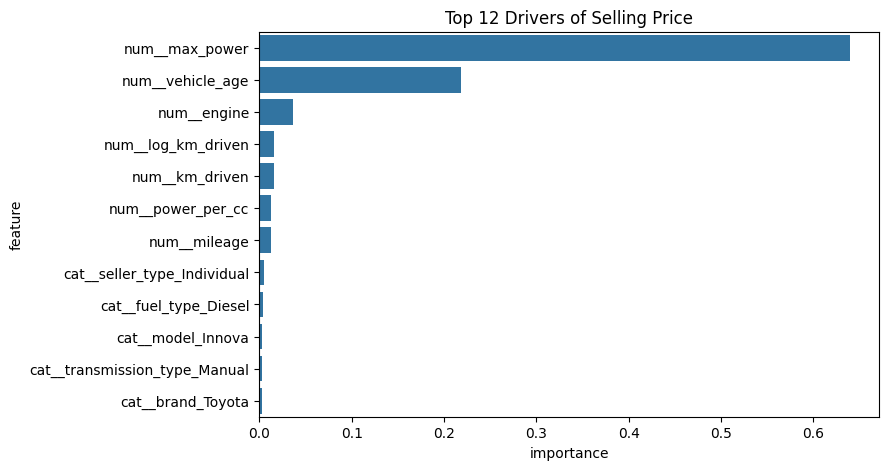

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=feature_importance.head(12),
    x="importance",
    y="feature"
)
plt.title("Top 12 Drivers of Selling Price")
plt.show()

##### 👉 Customers don’t just buy cars — they buy reputation + performance + risk reduction.

In [ ]:
# Feature Importance: What actually matters?
importances = rf_model.feature_importances_
feature_names = X_test.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.title("Top 10 Drivers of Price")
plt.show()

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [ ]:
# Residual Plot: Is the model biased?
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Analysis: Looking for Patterns")
plt.show()

In [ ]:
comparison = price_comparison.copy()

comparison["upper_bound"] = comparison["Predicted Price"] * 1.10
comparison["lower_bound"] = comparison["Predicted Price"] * 0.90

comparison.head()


In [ ]:
def decision_rule(row):
    if row["Actual Price"] < row["lower_bound"]:
        return "Strong Buy (Undervalued)"
    elif row["Actual Price"] > row["upper_bound"]:
        return "Overpriced (Avoid or Negotiate)"
    else:
        return "Fairly Priced"

comparison["decision"] = comparison.apply(decision_rule, axis=1)
comparison["decision"].value_counts()


### Customer Segmentation (Market Intelligence)

In [ ]:
comparison["segment"] = pd.qcut(
    comparison["Predicted Price"],
    q=3,
    labels=["Budget", "Premium", "Luxury"]
)

comparison["segment"].value_counts()
